# Going to Mars with Python using poliastro

<img src="http://docs.poliastro.space/en/latest/_images/logo_text.png" />

This is an example on how to use [poliastro](https://github.com/poliastro/poliastro), a little library I've been working on to use in my Astrodynamics lessons. It features conversion between **classical orbital elements** and position vectors, propagation of **Keplerian orbits**, initial orbit determination using the solution of the **Lambert's problem** and **orbit plotting**.

In this example we're going to draw the trajectory of the mission [Mars Science Laboratory (MSL)](http://mars.jpl.nasa.gov/msl/), which carried the rover Curiosity to the surface of Mars in a period of something less than 9 months.

**Note**: This is a very simplistic analysis which doesn't take into account many important factors of the mission, but can serve as an starting point for more serious computations (and as a side effect produces a beautiful plot at the end).

First of all, we import the necessary modules. Apart from poliastro we will make use of astropy to deal with physical units and time definitions and jplephem to compute the positions and velocities of the planets.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import astropy.units as u
from astropy import time

from poliastro import iod
from poliastro.bodies import Sun
from poliastro.twobody import Orbit

We need a binary file from NASA called *SPICE kernel* to compute the position and velocities of the planets. Astropy downloads it for us:

In [2]:
from astropy.coordinates import solar_system_ephemeris
from poliastro.ephem import get_body_ephem

solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

The initial data was gathered from Wikipedia: the date of the launch was on **November 26, 2011 at 15:02 UTC** and landing was on **August 6, 2012 at 05:17 UTC**. We compute then the time of flight, which is exactly what it sounds. It is a crucial parameter of the mission.

In [3]:
# Initial data
N = 50

date_launch = time.Time('2011-11-26 15:02', scale='utc')
date_arrival = time.Time('2012-08-06 05:17', scale='utc')
tof = (date_arrival - date_launch)

tof.to(u.h)

<Quantity 6086.250277777778 h>

With the date of launch and the date of landing we can compute the [Julian days](http://www.wikiwand.com/en/Julian_day). The Julian day is an integer assigned to a date, and it's useful for not having to deal with leap years, changes of calendar and other messy stuff. It is measured from around 4713 BC so it is a pretty big number, as we'll see:

In [4]:
# Calculate vector of times from launch and arrival Julian days
dt = (date_arrival - date_launch) / N

# Idea from http://docs.astropy.org/en/stable/time/#getting-started
times_vector = date_launch + dt * np.arange(N + 1)

Once we have the vector of times we can use `get_body_ephem` to compute the array of positions and velocities of the Earth and Mars.

In [5]:
rr_earth, vv_earth = get_body_ephem("earth", times_vector)

In [6]:
rr_earth[:, 0]

<Quantity [  6.46006434e+07,  1.21424866e+08,  5.26400473e+07] km>

In [7]:
vv_earth[:, 0]

<Quantity [-2352414.27027126, 1032013.3380897 ,  447276.92493007] km / d>

In [8]:
rr_mars, vv_mars = get_body_ephem("mars", times_vector)

In [9]:
rr_mars[:, 0]

<Quantity [ -1.23149631e+08,  1.90752511e+08,  9.08096543e+07] km>

In [10]:
vv_mars[:, 0]

<Quantity [-1730626.66251077, -811069.96095538, -325255.37513281] km / d>

To compute the transfer orbit, we have the useful function `lambert`: according to a theorem with the same name, *the transfer orbit between two points in space only depends on those two points and the time it takes to go from one to the other*. We have the starting and final position and we have the time of flight: there we go!

In [11]:
# Compute the transfer orbit!
r0 = rr_earth[:, 0]
rf = rr_mars[:, -1]

(va, vb), = iod.lambert(Sun.k, r0, rf, tof)

ss0_trans = Orbit.from_vectors(Sun, r0, va, date_launch)
ssf_trans = Orbit.from_vectors(Sun, rf, vb, date_arrival)

The rest of the code is boilerplate we need for a beautiful plot: we retrieve all the intermediate positions of the transfer orbit, and compute some more vectors outside of the mission time frame to decorate the plot.

<div class="alert alert-info">This code sucks. Pull requests welcome!</div>

In [12]:
# Extract whole orbit of Earth, Mars and transfer (for plotting)
rr_trans = np.zeros_like(rr_earth)
rr_trans[:, 0] = r0
for ii in range(1, len(times_vector)):
    tof = (times_vector[ii] - times_vector[0]).to(u.day)
    rr_trans[:, ii] = ss0_trans.propagate(tof).r

In [13]:
# Now compute the trail, better backwards
date_final = date_arrival - 1 * u.year
dt2 = (date_final - date_launch) / N

times_rest_vector = date_launch + dt2 * np.arange(N + 1)
rr_earth_rest, _ = get_body_ephem("earth", times_rest_vector)
rr_mars_rest, _ = get_body_ephem("mars", times_rest_vector)

<div class="alert alert-info">The positions are in the <strong>International Standard Reference Frame</strong>, which has the Equator as the fundamental plane</div>

And finally, we can plot the figure! There is no more magic here, just passing the position vectors to matplotlib `plot` function and adding some style to the plot.

<IPython.core.display.Javascript object>


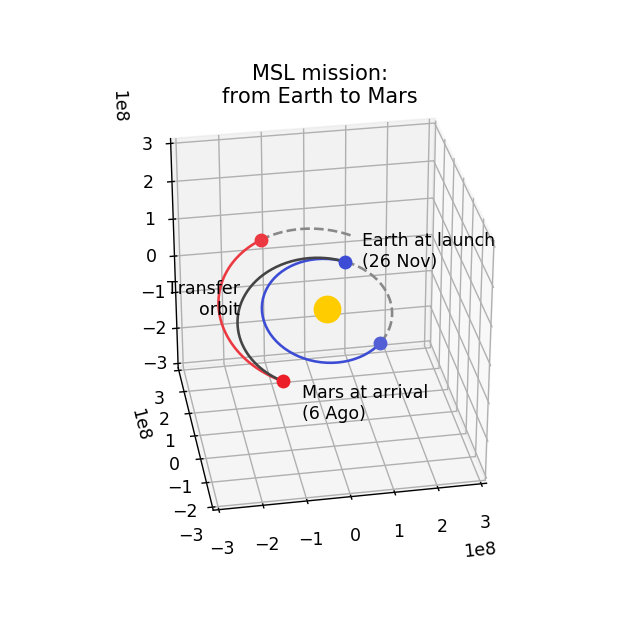

In [14]:
# Plot figure
# To add arrows:
# https://github.com/matplotlib/matplotlib/blob/v2.0.0/lib/matplotlib/streamplot.py#L172-L191

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

def plot_body(ax, r, color, size, border=False, **kwargs):
    """Plots body in axes object.

    """
    return ax.plot(*r[:, None], marker='o', color=color, ms=size, mew=int(border), **kwargs)

# I like color
color_earth0 = '#3d4cd5'
color_earthf = '#525fd5'
color_mars0 = '#ec3941'
color_marsf = '#ec1f28'
color_sun = '#ffcc00'
color_orbit = '#888888'
color_trans = '#444444'

# Plotting orbits is easy!
ax.plot(*rr_earth.to(u.km).value, c=color_earth0)
ax.plot(*rr_mars.to(u.km).value, c=color_mars0)

ax.plot(*rr_trans.to(u.km).value, c=color_trans)

ax.plot(*rr_earth_rest.to(u.km).value, ls='--', c=color_orbit)
ax.plot(*rr_mars_rest.to(u.km).value, ls='--', c=color_orbit)

# But plotting planets feels even magical!
plot_body(ax, np.zeros(3), color_sun, 16)

plot_body(ax, r0.to(u.km).value, color_earth0, 8)
plot_body(ax, rr_earth[:, -1].to(u.km).value, color_earthf, 8)

plot_body(ax, rr_mars[:, 0].to(u.km).value, color_mars0, 8)
plot_body(ax, rf.to(u.km).value, color_marsf, 8)

# Add some text
#ax.text(-0.75e8, -3.5e8, -1.5e8, "MSL mission:\nfrom Earth to Mars", size=20, ha='center', va='center', bbox={"pad": 30, "lw": 0, "fc": "w"})
ax.text(r0[0].to(u.km).value * 1.4, r0[1].to(u.km).value * 0.4, r0[2].to(u.km).value * 1.25,
        "Earth at launch\n(26 Nov)", ha="left", va="bottom")#, backgroundcolor='#ffffff')
ax.text(rf[0].to(u.km).value * 0.7, rf[1].to(u.km).value * 1.1, rf[2].to(u.km).value,
        "Mars at arrival\n(6 Ago)", ha="left", va="top")#, backgroundcolor='#ffffff')
ax.text(-1.9e8, 8e7, 0, "Transfer\norbit", ha="right", va="center")#, backgroundcolor='#ffffff')

# Tune axes
ax.set_xlim(-3e8, 3e8)
ax.set_ylim(-3e8, 3e8)
ax.set_zlim(-3e8, 3e8)

# And finally!
ax.view_init(30, 260)
ax.set_title("MSL mission:\nfrom Earth to Mars")
fig.savefig("trans_30_260.png", bbox_inches='tight')

And now, let's do it interactively!

In [15]:
def go_to_mars(offset=0., tof_=6000.):
    # Initial data
    N = 50

    date_launch = time.Time('2011-11-26 15:02', scale='utc') + offset * u.day
    #date_arrival = time.Time('2012-08-06 05:17', scale='utc')
    tof = tof_ * u.h

    # Calculate vector of times from launch and arrival
    date_arrival = date_launch + tof
    dt = (date_arrival - date_launch) / N

    # Idea from http://docs.astropy.org/en/stable/time/#getting-started
    times_vector = date_launch + dt * np.arange(N + 1)

    rr_earth, vv_earth = get_body_ephem("earth", times_vector)
    rr_mars, vv_mars = get_body_ephem("mars", times_vector)

    # Compute the transfer orbit!
    r0 = rr_earth[:, 0]
    rf = rr_mars[:, -1]

    (va, vb), = iod.lambert(Sun.k, r0, rf, tof)

    ss0_trans = Orbit.from_vectors(Sun, r0, va, date_launch)
    ssf_trans = Orbit.from_vectors(Sun, rf, vb, date_arrival)

    # Extract whole orbit of Earth, Mars and transfer (for plotting)
    rr_trans = np.zeros_like(rr_earth)
    rr_trans[:, 0] = r0
    for ii in range(1, len(times_vector)):
        tof = (times_vector[ii] - times_vector[0]).to(u.day)
        rr_trans[:, ii] = ss0_trans.propagate(tof).r

    # Better compute backwards
    date_final = date_arrival - 1 * u.year
    dt2 = (date_final - date_launch) / N

    times_rest_vector = date_launch + dt2 * np.arange(N + 1)
    rr_earth_rest, _ = get_body_ephem("earth", times_rest_vector)
    rr_mars_rest, _ = get_body_ephem("mars", times_rest_vector)

    # Plot figure
    fig = plt.gcf()
    ax = plt.gca()
    ax.cla()

    def plot_body(ax, r, color, size, border=False, **kwargs):
        """Plots body in axes object.

        """
        return ax.plot(*r[:, None], marker='o', color=color, ms=size, mew=int(border), **kwargs)

    # I like color
    color_earth0 = '#3d4cd5'
    color_earthf = '#525fd5'
    color_mars0 = '#ec3941'
    color_marsf = '#ec1f28'
    color_sun = '#ffcc00'
    color_orbit = '#888888'
    color_trans = '#444444'

    # Plotting orbits is easy!
    ax.plot(*rr_earth.to(u.km).value, color=color_earth0)
    ax.plot(*rr_mars.to(u.km).value, color=color_mars0)

    ax.plot(*rr_trans.to(u.km).value, color=color_trans)
    ax.plot(*rr_earth_rest.to(u.km).value, ls='--', color=color_orbit)
    ax.plot(*rr_mars_rest.to(u.km).value, ls='--', color=color_orbit)

    # But plotting planets feels even magical!
    plot_body(ax, np.zeros(3), color_sun, 16)

    plot_body(ax, r0.to(u.km).value, color_earth0, 8)
    plot_body(ax, rr_earth[:, -1].to(u.km).value, color_earthf, 8)

    plot_body(ax, rr_mars[:, 0].to(u.km).value, color_mars0, 8)
    plot_body(ax, rf.to(u.km).value, color_marsf, 8)

    # Add some text
    #ax.text(-0.75e8, -3.5e8, -1.5e8, "MSL mission:\nfrom Earth to Mars", size=20, ha='center', va='center', bbox={"pad": 30, "lw": 0, "fc": "w"})
    ax.text(r0[0].to(u.km).value * 1.4, r0[1].to(u.km).value * 0.4, r0[2].to(u.km).value * 1.25,
            "Earth at launch\n({0:%b %d})".format(date_launch.datetime),
            ha="left", va="bottom", backgroundcolor='#ffffff')
    ax.text(rf[0].to(u.km).value * 0.7, rf[1].to(u.km).value * 1.1, rf[2].to(u.km).value,
            "Mars at arrival\n({0:%b %d})".format(date_arrival.datetime),
            ha="left", va="top", backgroundcolor='#ffffff')
    ax.text(-1.9e8, 8e7, 0, "Transfer\norbit", ha="right", va="center", backgroundcolor='#ffffff')

    # Tune axes
    ax.set_xlim(-3e8, 3e8)
    ax.set_ylim(-3e8, 3e8)
    ax.set_zlim(-3e8, 3e8)
    ax.view_init(30, 260)

<IPython.core.display.Javascript object>


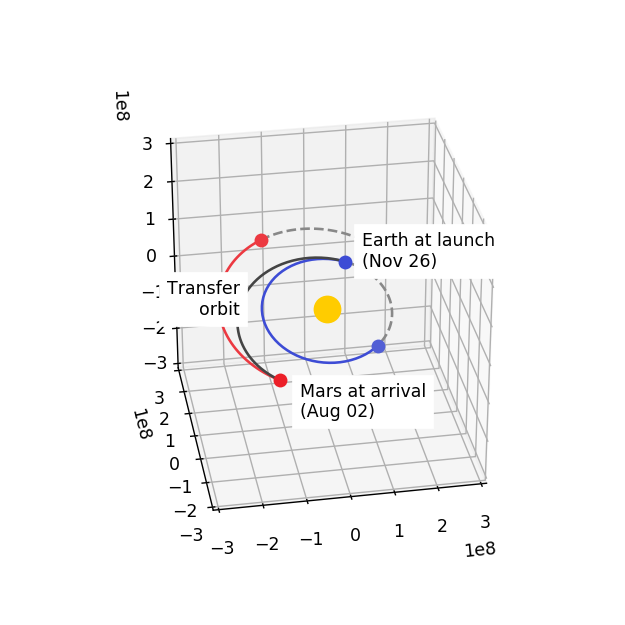

In [16]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

go_to_mars();

In [17]:
from ipywidgets import interact

interact(go_to_mars, offset=(-100., 300.), tof_=(100., 12000.));

Widget Javascript not detected.  It may not be installed or enabled properly.


Not bad! Hope you found it interesting. In case you didn't but are still reading, here is some music that you may enjoy:

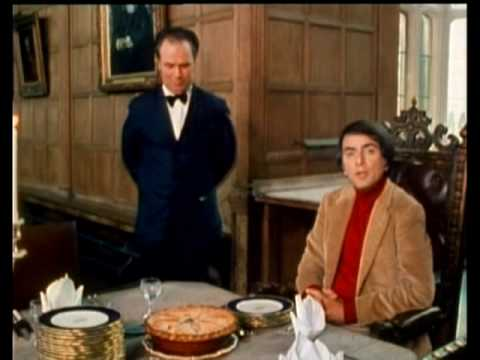

In [18]:
from IPython.display import YouTubeVideo
YouTubeVideo('zSgiXGELjbc')